# Machine Project 6: EDGAR Web Logs

#### <span style="color:red">Make sure to read the [README](README.md) before starting this project</span>

## Required Information

Please fill out the following details.  
- Enter your **full name (as it appears on Canvas)** and **NetID**.  
- If you are working in a group (maximum of 4 members), include the **full names and NetIDs** of all your partners.  
- If you're working alone, enter `None` for the partner fields.

> **Important:** Each student must submit the project individually.  
Failure to complete this section may result in your submission being flagged for plagiarism.

In [1]:
# Project: MP6
# Student 1: vardaan kapoor, vkapoor5

## <span style="color:red">Important:</span>

* **Before you begin**, make sure to `pull` any changes from GitLab. From the terminal, run:
```
git checkout main
git pull
git checkout MP6
git merge main
```
* Follow all instructions carefully. If anything is unclear, attend office hours or post on Piazza.
* You may add additional code cells as needed. However, **only cells with `#Q_` in the code will be graded**.
* To test, **Restart and Run all Cells** then **save the notebook** and run `python3 tester.py` from the terminal

> ⚠️ **Reminders:**
>
> - Make sure you are on the `MP6` branch by running `git branch` and checking the output.
> - Frequently `add`, `commit`, and `push` your code to avoid losing progress.


In [2]:
# Add additional imports used throughout the project here

# these lines automatically reload modules when their code changes
%load_ext autoreload
%autoreload 2




In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import graphviz
import pickle # used for grading graphs
from zipfile import ZipFile
import zipfile
from io import TextIOWrapper
import numpy as np
from edgar_utils import lookup_region
from subprocess import check_output
from collections import defaultdict

# Group Part (75%)

For this portion of the machine project, you may collaborate with your group members in any way (including looking at group members' code). You may also seek help from CS 320 course staff (peer mentors, TAs, and the instructor). You **may not** seek or receive help from other CS 320 students (outside of your group) or anybody else outside of the course.

## Part 1: `server_log.zip` analysis
> 📄 **Work in:** [`mp6.ipynb`](mp6.ipynb)

In [4]:
# Use pandas to read in "server_log.zip as a csv file"
with ZipFile("server_log.zip") as zf:
    with zf.open("rows.csv") as f:
        df=pd.read_csv(f)
        print(df.head(n=5))

               ip        date      time  zone        cik  \
0  104.197.32.ihd  2017-01-01  00:00:00   0.0  1111711.0   
1  208.77.214.jeh  2017-01-01  00:00:00   0.0   789019.0   
2  54.197.228.dbe  2017-01-01  00:00:00   0.0   800166.0   
3  108.39.205.jga  2017-01-01  00:00:01   0.0   354950.0   
4   52.45.218.ihf  2017-01-01  00:00:01   0.0  1313918.0   

              accession   extention   code     size  idx  norefer  noagent  \
0  0001193125-12-324016  -index.htm  200.0   7627.0  1.0      0.0      0.0   
1  0001193125-06-031505        .txt  200.0  46327.0  0.0      0.0      0.0   
2  0001279569-16-003038  -index.htm  200.0  16414.0  1.0      0.0      0.0   
3  0000950123-09-011236  -index.htm  200.0   8718.0  1.0      0.0      0.0   
4  0001209191-06-031555        .txt  200.0   8911.0  0.0      0.0      0.0   

   find  crawler  browser  
0  10.0      0.0      NaN  
1  10.0      0.0      NaN  
2  10.0      0.0      NaN  
3  10.0      0.0      NaN  
4  10.0      0.0      NaN  


### Q1: What's the total size in bytes of the files requested?

Look at the `size` column of the CSV in `server_log.zip`.  We want to include duplicates here; this gives us an estimate of the amount of network traffic handled by EDGAR (since this data is only a sample, the true value will be even larger). Answer with an integer. 

**Note:** If you use `numpy` make sure to cast the final answer to an `int`.

In [5]:
#Q1
sizeCol=df["size"]
(int)(sizeCol.sum())

24801002666

### Q2: How many filings have been accessed by the 10 IPs with the most accesses?

Answer with a dictionary, with the (anonymized) IP as key and the number of requests seen in the logs as the values. Each row in the logs corresponds to one request. Note that the anonymized IP addresses are consistent between requests.

**Hint:** for this question and most of the others expecting dictionary output, it might be easiest to use Pandas operations to process the data into a `Series` and to use the `to_dict()` method. Consider using tools like `groupby`, `apply`, and aggregation methods like `size()`. In Q30-32 from [MP1](../mp1/README.md), there is an example of `apply`.


In [6]:
#Q2
top10ip=df.groupby("ip").size().sort_values(ascending=False).head(10)
top10ip.to_dict()

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

In [7]:
def findErrors():
    c=0
    for row in df.itertuples():
        if(row[8]>400):
            c+=1
    return c

### Q3: What fraction of the requests had errors?

Any request with a status code greater than or equal to 400 has an error. Answer with a floating point number. 

**Note:** If you use `numpy` make sure to cast the final answer to a `float`.

In [8]:
#Q3

findErrors()/len(df)

    

0.03466852724527611

In [9]:
def createFileFormatting(row):
    return "{}/{}/{}".format((int)(row["cik"]),row["accession"],row["extention"])

    

### Q4: What is the second most frequently accessed file?

Answer with a string formatted like so: "cik/accession/extention" (these are the names of columns in "rows.csv").

In [10]:

df["concatSt"]=df.apply(createFileFormatting,axis=1)


In [11]:
#Q4
file_counts = df.groupby("concatSt").size().reset_index(name="count")
second_file = file_counts.sort_values("count", ascending=False).iloc[1]
second_file["concatSt"]

'1584509/0001584509-16-000514/armk-20160930_def.xml'

In [12]:
sampledf = df
sampledf['cik'] = sampledf['cik'].astype(int)


## Part 2: Creating `edgar_utils.py` module
> 📄 **Work in:** [`edgar_utils.py`](edgar_utils.py)

This part is to be started during [Lab 9](../../labs/Lab9/README.md). Finish the `edgar_utils.py` module now if you didn't have enough time
during the scheduled lab.

## Part 3: Using `edgar_utils.py` module
> 📄 **Work in:** [`mp6.ipynb`](mp6.ipynb)

In [13]:
from edgar_utils import Filing

In [14]:
sampledf['region'] = sampledf['ip'].apply(lookup_region)

/home/varda/labs-and-projects/projects/mp6/edgar_utils.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.iloc[index-1][3]


### Q5: Which region accesses resources most heavily in `server_log.zip`?

Use your `lookup_region` function and answer with a string.

In [15]:
 def getSortedCountries(df):
        countriesList={}
        for row in df.itertuples():
            countryName=lookup_region(row[1])
            if(countryName in countriesList):
                countriesList[countryName]+=1
            else:
                countriesList[countryName]=1
        return countriesList
    

In [16]:

countriesList=getSortedCountries(df)

/home/varda/labs-and-projects/projects/mp6/edgar_utils.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.iloc[index-1][3]


In [17]:
#Q5
sorted_items = sorted(countriesList.items(), key=lambda item: item[1], reverse=True)
sorted_items[0][0]

'United States of America'

### Q6: What fraction of IPs in each region are high-volume users?

Consider IPs which accessed more than 300 EDGAR resoures to be
high-volume. This might indicate machines running automated scraping
and analysis tasks.

Note that given the sampling done in the data, the true EDGAR usage of
these machines is likely to be even heavier.

Answer with a dictionary, where the keys are the regions and the
values are the fraction (in floating point form) of IPs from that
region classified as high-volume.

**Example:**

Say "United States of America" has four IPs:
* 1.1.1.1 appears 1200 times in the logs
* 2.2.2.2 appears 900 times in the logs
* 3.3.3.3 appears 5 times in the logs
* 4.4.4.4 appears 234 times in the logs

This means that 1/2 of the IPs in the US are high volume, so there should be an entry like this:

```
{
    "United States of America": 0.5,
    ...
}
```

**Note:** Some of the filings are listed as having a region of '-'. Please include this in your final
answer.

**Note:** If you use `numpy` make sure to cast dictionary entries to `float`.

In [18]:
 def getSortedIP(df):
        ipList={}
        countriesList={}
        countriesTotal={}
        for row in df.itertuples():
            ip=row[1]
            if(ip in ipList):
                ipList[ip]+=1
            else:
                ipList[ip]=1
        for key,value in ipList.items():
            country=lookup_region(key)
            if country in countriesTotal:
                countriesTotal[country]+=1
            else:
                countriesTotal[country]=1
            if value>300:
                if country in countriesList:
                    countriesList[country]+=1
                else:
                    countriesList[country]=1
                    
        return (countriesList,countriesTotal)

In [19]:
cl,ct=getSortedIP(df)

In [20]:
#Q6
listCountries={}
keysCL=cl.keys()
for key,value in ct.items():
    if key not in keysCL:
        listCountries[key]=0.0
    else:
        listCountries[key]=cl[key]/ct[key]
listCountries

{'United States of America': 0.04889228418640183,
 'China': 0.016018306636155607,
 'Hong Kong': 0.037037037037037035,
 'Ireland': 0.625,
 'Canada': 0.05357142857142857,
 'United Kingdom of Great Britain and Northern Ireland': 0.08888888888888889,
 'Czechia': 0.3333333333333333,
 'Germany': 0.047619047619047616,
 'Bulgaria': 0.3333333333333333,
 'France': 0.0036900369003690036,
 'India': 0.08823529411764706,
 'Korea (Republic of)': 0.2,
 'Australia': 0.07692307692307693,
 'Spain': 0.0,
 'Netherlands': 0.0,
 'Sweden': 0.0,
 'Sudan': 0.0,
 'Estonia': 0.0,
 'Russian Federation': 0.0,
 'Tanzania, United Republic of': 0.0,
 'Yemen': 0.0,
 'Algeria': 0.0,
 'Ukraine': 0.0,
 'Slovakia': 0.0,
 'Viet Nam': 0.0,
 'Denmark': 0.0,
 'Singapore': 0.0,
 'Switzerland': 0.0,
 'Thailand': 0.0,
 'South Africa': 0.0,
 'Italy': 0.0,
 'Poland': 0.0,
 'Taiwan (Province of China)': 0.0,
 'Brazil': 0.0,
 'Morocco': 0.0,
 'Malaysia': 0.0,
 'Hungary': 0.0,
 'Japan': 0.0,
 'Luxembourg': 0.0,
 'Romania': 0.0,
 'Libe

### Requirement: `filings` dictionary

Read every file ending with .htm or .html in `docs.zip`, and create a `Filing`
object based on that file. Then, save that `Filing` object to a dictionary as follows:
- **Key:** The filepath for this filing object (ex. `850693/0000850693-07-000159/-index.htm`)
- **Value:** The `Filing` object created from this filepath.

Creating this dictionary once now will save us from needing to loop over all values
in future questions.

In [21]:
l=str(check_output(["unzip","-l","docs.zip"]),encoding="utf-8")

In [22]:
def createFilingsDict(fileName):
    filingsDict={}
    c=0
    with ZipFile(fileName) as zf:
        for line in l.splitlines():
            if(line.endswith(".htm") or line.endswith(".html")):
                path=line.split(" ")[-1]
                with zf.open(path) as f:
                    contents=str(f.read())
                    fileObj=Filing(contents)
                    filingsDict[path]=fileObj
    return filingsDict
            
            

In [23]:
# Create `filings` dictionary
filDict=createFilingsDict("docs.zip")

In [24]:
filings_dict = {}
with zipfile.ZipFile('docs.zip', 'r') as z:
    for file in z.namelist():
        if file.endswith(('.htm', '.html')):
            with z.open(file) as f:
                html_content = f.read().decode('utf-8', errors='ignore') 
                filing = Filing(html_content) 
                filings_dict[file] = filing 

### Q7: What dates appear in the `886982/0000769993-16-001958/-index.htm` file of `docs.zip`?

Read the HTML from this file and use it to create a `Filing` object,
from which you can access the `.dates` attribute.

In [25]:
#Q7
fObj=filDict["886982/0000769993-16-001958/-index.htm"]
fObj.dates

['2016-12-30', '2016-12-30', '2016-12-20']

### Q8: What is the distribution of states for the filings in `docs.zip`?

Answer with a dict, like the following:

```
{'CA': 92,
 'NY': 83,
 'TX': 67,
 'None': 56,
 'MA': 30,
 'IL': 25,
 'PA': 25,
 'CO': 25,
 ...
}
```

The showing order of each key-value pair doesn't really matter. Please include `None` in the
dictionary.

**Hint:** We created the `filings` dictionary above, which means we don't have to
iterate through `docs.zip` here again!

In [26]:
#Q8
from collections import Counter
counter = Counter()
for filing in filDict.values():
    state = filing.state()  
    if state:
        counter[state] += 1 
    else:
        counter[None] += 1  

state_distribution = dict(sorted(counter.items(), key=lambda x: (x[0] is None, x[0])))
state_distribution


{'AL': 1,
 'AR': 1,
 'AZ': 5,
 'CA': 92,
 'CO': 25,
 'CT': 14,
 'DC': 1,
 'DE': 9,
 'FL': 21,
 'GA': 9,
 'IA': 6,
 'ID': 1,
 'IL': 25,
 'IN': 5,
 'KS': 5,
 'KY': 2,
 'LA': 2,
 'MA': 30,
 'MD': 13,
 'ME': 1,
 'MI': 11,
 'MN': 15,
 'MO': 4,
 'MS': 1,
 'NC': 9,
 'NE': 2,
 'NJ': 23,
 'NM': 1,
 'NV': 6,
 'NY': 83,
 'OH': 10,
 'OK': 7,
 'OR': 2,
 'PA': 25,
 'SD': 1,
 'TN': 4,
 'TX': 67,
 'UT': 5,
 'VA': 15,
 'VT': 1,
 'WA': 3,
 'WI': 9,
 'WV': 2,
 None: 56}

### Q9: What is the distribution for the ten most common addresses for the filings in `docs.zip`?

Answer in the same format as the previous question.

Expected output:
```
{'2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067': 134,
 '2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067\n3102014100': 113,
 '3 LANDMARK SQUARE\nSUITE 500\nSTAMFORD CT 06901\n2033564400': 60,
 'C/O KKR ASSET MANAGEMENT LLC\n555 CALIFORNIA STREET, 50TH FLOOR\nSAN FRANCISCO CA 94104': 36,
 'C/O ARES MANAGEMENT LLC\n2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067': 35,
 '4740 AGAR DRIVE\nRICHMOND A1 V7B 1A3': 25,
 'CENTRALIS S.A., 8-10 AVENUE DE LA GARE\nLUXEMBOURG N4 L-1610': 25,
 'CENTRALIS S.A., 8-10 AVENUE DE LA GARE\nLUXEMBOURG N4 L-1610\n352-26-186-1': 25,
 '3 LANDMARK SQUARE\nSUITE 500\nSTAMFORD CT 06901': 24,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 22}
```

In [27]:
#Q9
addr_counter = Counter()
for filing in filings_dict.values():
    for addr in filing.addresses:
        if not addr.strip():   # skip empty or all‑whitespace strings
            continue
        addr_counter[addr] += 1

top_10_addresses = dict(addr_counter.most_common(10))
top_10_addresses




{'2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067': 134,
 '2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067\n3102014100': 113,
 '3 LANDMARK SQUARE\nSUITE 500\nSTAMFORD CT 06901\n2033564400': 60,
 'C/O KKR ASSET MANAGEMENT LLC\n555 CALIFORNIA STREET, 50TH FLOOR\nSAN FRANCISCO CA 94104': 36,
 'C/O ARES MANAGEMENT LLC\n2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067': 35,
 '4740 AGAR DRIVE\nRICHMOND A1 V7B 1A3': 25,
 'CENTRALIS S.A., 8-10 AVENUE DE LA GARE\nLUXEMBOURG N4 L-1610': 25,
 'CENTRALIS S.A., 8-10 AVENUE DE LA GARE\nLUXEMBOURG N4 L-1610\n352-26-186-1': 25,
 '3 LANDMARK SQUARE\nSUITE 500\nSTAMFORD CT 06901': 24,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 22}

# Individual Part (25%)

For this portion of the machine project, you are only allowed to seek help from CS 320 course staff (peer mentors, TAs, and the instructor). You **may not** receive help from anyone else.

## Part 4: Combining logs with documents
> 📄 **Work in:** [`mp6.ipynb`](mp6.ipynb)

### Q10: What is the distribution of requests across industries?

For each request in the logs that has a corresponding filing in
`docs.zip`, lookup the SIC (ignore rows in the logs which refer to
pages not in `docs.zip`).

Answer with a dictionary, where the keys are the SIC and the values
are the number of times the resources of that industry were accessed.

If you're curious, consider looking up the industry names for the top
couple categories:
https://www.sec.gov/corpfin/division-of-corporation-finance-standard-industrial-classification-sic-code-list

Expected output:

```
{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 6022: 379,
 1000: 273,
 ...
 }
 ```

In [28]:
#Q10
def get_sic_distribution(df, filings_dict):
    df['cik'] = df['cik'].astype(int)
    sic_distribution = defaultdict(int)
    for _, row in df.iterrows():
        path = f"{row['cik']}/{row['accession']}/{row['extention']}"
        if path in filings_dict:
            filing_obj = filings_dict[path]
            sic = filing_obj.sic
            if sic is not None:
                sic_distribution[sic] += 1
    result = dict(sic_distribution)
    result_sorted = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
    return result_sorted

sic_distribution = get_sic_distribution(df, filings_dict)
sic_distribution

{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 6022: 379,
 1000: 273,
 6211: 237,
 7371: 229,
 2860: 226,
 6021: 204,
 6282: 171,
 2510: 171,
 3825: 164,
 4841: 108,
 5621: 99,
 7200: 94,
 7374: 94,
 6331: 91,
 6798: 90,
 5311: 90,
 3842: 87,
 6221: 85,
 6029: 83,
 3272: 81,
 3829: 73,
 4931: 70,
 3510: 66,
 7830: 62,
 3826: 56,
 3695: 55,
 3620: 50,
 7373: 48,
 6799: 46,
 4412: 43,
 4512: 42,
 7340: 40,
 7370: 39,
 900: 39,
 6513: 38,
 3621: 38,
 5172: 36,
 5900: 35,
 4213: 35,
 3990: 34,
 5122: 34,
 5944: 33,
 2070: 33,
 8090: 32,
 1700: 31,
 3312: 31,
 1381: 31,
 4922: 31,
 6324: 30,
 8742: 27,
 7389: 26,
 8731: 25,
 7812: 25,
 3590: 24,
 4955: 23,
 3663: 23,
 4522: 22,
 6321: 21,
 3559: 20,
 5812: 19,
 6792: 19,
 6189: 18,
 7372: 16,
 3841: 14,
 6199: 11,
 1731: 11,
 4911: 8,
 4833: 7,
 6035: 7,
 3571: 6,
 2430: 6,
 3679: 5,
 3674: 5,
 4813: 4,
 3678: 4,
 4812: 4,
 1531: 4,
 5500: 4,
 6411: 3,
 1400: 3,
 2800: 3,
 3420: 3,
 8062: 3,
 3576: 3,
 2870: 2,
 1040: 2,
 8711: 2,
 3669: 


### Q11: How many requests were made in each hour?

Use `pd.to_datetime` (the `hour` attributes of the converted
timestamps may be useful) or string manipulation to process the `time`
column. Answer with a dictionary, where the keys are integers from 0
to 23 representing the hour of the day, and the values are the number
of requests made in that hour.

In [29]:
#Q11
df["ts"] = pd.to_datetime(df["time"], errors="coerce")

# 2. Extract the hour (0–23)
df["hour"] = df["ts"].dt.hour

# 3. Count requests per hour, ensure all 0–23 are present
hour_counts = df["hour"].value_counts().sort_index().to_dict()
# Fill in any missing hours with zero
hourly_requests = {h: hour_counts.get(h, 0) for h in range(24)}

hourly_requests

/tmp/ipykernel_591200/558374133.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ts"] = pd.to_datetime(df["time"], errors="coerce")


{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

### Q12: What is the geographic overlap in interest between Australia, France, Indonesia, and Viet Nam?

Answer with a Digraph like the following:

<img src="img/digraph.png" width=400>

In addition to a node for each of these three countries, there should
be a node for each state having a filing accessed by somebody in one
of these countries.

An edge from a country to a state means somebody in that country
looked at least one filing for a company in that state.

**Important:** Make sure not to hardcode these values. It might be helpful to
define a list like `countries = ["Australia", "France", "Indonesia", "Viet Nam"]` and then loop over the filings for these countries only.

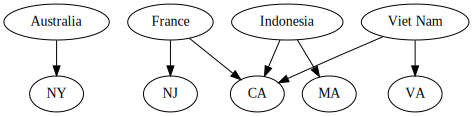

In [30]:
#Q12

d = graphviz.Digraph(comment="hello")
sampledf['cikaccex'] = sampledf['cik'].astype(int).astype(str)+"/"+sampledf['accession'].astype(str)+"/"+sampledf['extention'].astype(str)

countries = ["Australia", "France", "Indonesia", "Viet Nam"]
states = []
region_df = {}
regions = sampledf['region']
for filing in filings_dict.values():
    state = filing.state()  
    states.append(state)

for i in countries:  
    region_df[i] = set()
    

for i in sampledf.itertuples():
    places = i.region

    if places in region_df:
        if i.cikaccex in filings_dict:
            state = filings_dict[i.cikaccex].state()
            region_df[places].add(state)
                   
for country in countries:
    for state in region_df[country]:
        d.edge(country, state)



# IMPORTANT -- Do not remove -- 
with open("Q12.pkl", "wb") as f:
    pickle.dump(d.source, f)

d



### Q13: Geographic Plotting of Postal Codes

In this question, you will plot geographic data from `locations.geojson` over a background map from the shapefile `"shapes/cb_2018_us_state_20m.shp"`. Each point represents an address and should be colored by its **postal code**.

Follow the instructions **carefully**, as this question involves geospatial data manipulation that is sensitive to the order of operations.

**Required Steps:**

1. Extract ZIP codes from the address column:
   - Use a regular expression to extract the **5-digit** ZIP code from the address string.
   - Ignore entries with missing or malformed ZIP codes.
   - If a ZIP code has a state and then the code, make sure to only take the 5 digit code. For example, only use `93821` in `CA 93821`.

2. Filter valid ZIP codes:
   - Only keep rows where the ZIP code is a number between **10000** and **60000**.

3. Crop the data to a specific bounding box (do this **before** projecting):
   - Define the bounding box:  
     `west = -90`, `east = -65`, `south = 25`, `north = 50`
   - Use `shapely.geometry.box(west, south, east, north)` to create a bounding box and either `.intersection()` to crop the background or `.intersects()` to filter the data points.

4. Project to Mercator ("epsg:2022"):
   - After filtering, apply `.to_crs("epsg:2022")` **to both** the background and the locations.

5. Plot:
   - Use `.plot(ax=ax)` and be sure to **pass the same `ax` object** to both the background and the points.
   - Set:
     - Background color to `"lightgray"`
     - Point colors using the `"viridis"` colormap
     - Color of each point should represent the ZIP code using `column="zipcode"` in `.plot(...)`.
     - Add a colorbar with `legend=True`
     - Remove axis labels with `ax.set_axis_off()`

The result should look similar to this:

<img src="img/geo.png" width="400px">

**Hints:**

- **Do not project before filtering or intersecting with the bounding box.** Always crop in latitude/longitude (the original coordinate system) first.
- Use `re.findall(regex, address)` to extract ZIP codes.
- Clean the data **before** plotting.
- If your map looks distorted or blank, double-check that you projected **after** cropping and used the correct EPSG code.
- Double-check the ZIP code range: it must be between 10000 and 60000.
- Use `legend=True` for the colorbar.


In [31]:
west = -90
east = -65
north = 50
south = 25

135
30


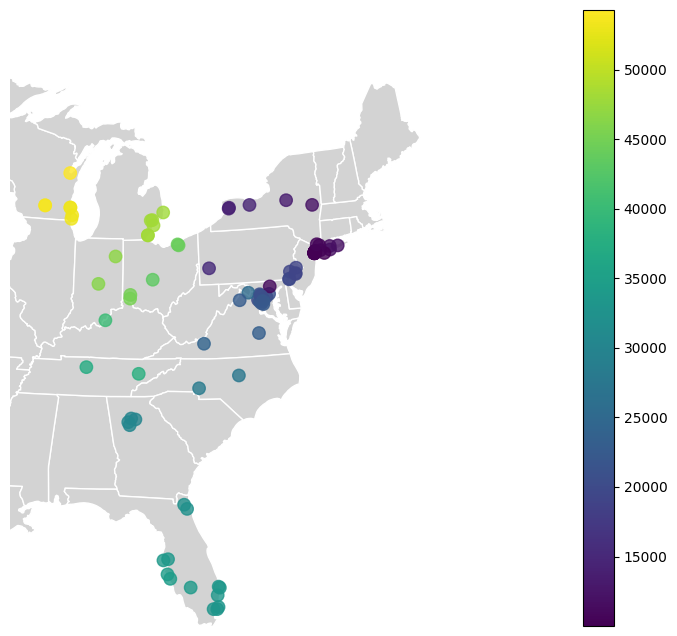

In [32]:
#Q13
import re
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box, Point

# 1) Read the data
locations = gpd.read_file("locations.geojson")
background = gpd.read_file("shapes/cb_2018_us_state_20m.shp")

# 2) Extract postal codes using re.findall(), taking the last 5‑digit match
def extract_postal_code(addr):
    matches = re.findall(r'\b\d{5}\b', addr or "")
    return int(matches[-1]) if matches else None

locations['postal_code'] = locations['address'].apply(extract_postal_code)

# 3) Drop rows without a postal code, cast to int, and filter valid range
locations = locations.dropna(subset=['postal_code'])
locations['postal_code'] = locations['postal_code'].astype(int)
locations = locations[locations['postal_code'].between(10000, 60000)].copy()
print(len(locations))

# 4) Define the lat/lon bounding box (pre‑projection)
west, east, south, north = -90, -65, 25, 50
bbox = box(west, south, east, north)

# 5) Exclude DC & territories so only the 48 contiguous states remain
exclude = ["DC", "PR", "GU", "VI", "AS", "MP"]
background = background[~background['STUSPS'].isin(exclude)].copy()

# 6) Crop both layers to the bounding box (still in EPSG:4326)
background = background[background.geometry.intersects(bbox)].copy()
locations  = locations[locations.geometry.intersects(bbox)].copy()
print(len(background))
# 7) Project both to Mercator (EPSG:2022)
background = background.to_crs("EPSG:2022")
locations  = locations.to_crs("EPSG:2022")

# 8) Compute projected bbox limits for exact zoom
minx, miny, maxx, maxy = (
    gpd.GeoSeries(bbox, crs="EPSG:4326")
       .to_crs("EPSG:2022")
       .total_bounds
)

fig, ax = plt.subplots(figsize=(10, 8))
background.plot(ax=ax, color="lightgray", edgecolor="white")
locations.plot(
    ax=ax,
    column='postal_code',
    cmap='viridis',
    legend=True,
    markersize=80,
    alpha=0.8
)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()


with open("Q13.pkl", "wb") as f:
    pickle.dump(fig, f)

plt.show()



In [33]:
def filterCodes(locations1):
    new=[]
    for row in locations1.itertuples():
        address=str(row[1])
        l=re.findall(r"\b\d{5}\b$",address)
        if len(l)>0:
            code=(int)(l[0])
            if code>=10000 and code<=60000:
                new.append(row)
    return new
    

In [34]:
def addNewCol(row):
    address=row[1]
    l=re.findall(r"\b\d{5}\b$",address)
    code=(int)(l[0])
    return "{}".format(code)

In [35]:
import re
import geopandas as gpd

# 1) Read the locations data
locations = gpd.read_file("locations.geojson")

locationsFiltered=filterCodes(locations)
print(type(locationsFiltered))
print(len(locationsFiltered))
"""
def createFileFormatting(row):
    return "{}/{}/{}".format((int)(row["cik"]),row["accession"],row["extention"])
df["concatSt"]=df.apply(createFileFormatting,axis=1)
    
    """



<class 'list'>
129


'\ndef createFileFormatting(row):\n    return "{}/{}/{}".format((int)(row["cik"]),row["accession"],row["extention"])\ndf["concatSt"]=df.apply(createFileFormatting,axis=1)\n    \n    '

## <span style="color:red">Important:</span>
Make sure to follow these steps to submit the project
1. **Kernel > Restart Kernel and Run All Cells** and then save the notebook
2. Run `tester.py` to check your answers
3. Run the following commands from the terminal:
```
git status # make sure you are in the correct branch
git add <required files>
git commit -m "Some message"
git push
```
4. Once you've pushed your project to GitLab, **verify that the pipeline ran successfully**.
    * Build > Jobs > Select the latest commit hash > Check tester output
5. Create a **_merge request_** to submit the project
    * Code > Merge requests > New merge request